We begin by importing our data and taking a look at the column names

In [1]:
import pandas as pd
import numpy as np
cars = pd.read_csv('cars_cleaned.csv')
cars.columns

Index(['condition', 'drive', 'fuel', 'location', 'odometer', 'paint color',
       'price', 'sale type', 'title status', 'transmission', 'type',
       'cylinders', 'size', 'latitude', 'longitude', 'location_simple', 'year',
       'age', 'make_', 'model', 'pos_words', 'neg_words', 'low_text', 'model0',
       'model1', 'model2'],
      dtype='object')

In [2]:
#look at the first few lines of data
cars.head()

,condition,drive,fuel,location,odometer,paint color,price,sale type,title status,transmission,...,year,age,make_,model,pos_words,neg_words,low_text,model0,model1,model2
0,good,4wd,gas,vancouver,281000,white,5500,owner,rebuilt,automatic,...,2007,14,bmw,x3,False,False,False,x3,None,None
1,unknown,fwd,gas,vancouver,140000,unknown,600,owner,clean,automatic,...,1984,37,honda,accord,False,False,False,accord,None,None
2,excellent,rwd,diesel,vancouver,110000,white,67000,owner,clean,automatic,...,2008,13,gmc,c7500,False,False,False,c7500,None,None
3,unknown,fwd,gas,vancouver,243000,unknown,4000,owner,clean,automatic,...,2003,18,acura,rsx,True,False,False,rsx,None,None
4,salvage,fwd,gas,vancouver,225000,black,1500,owner,salvage,automatic,...,2005,16,acura,rsx,False,False,False,rsx,None,None


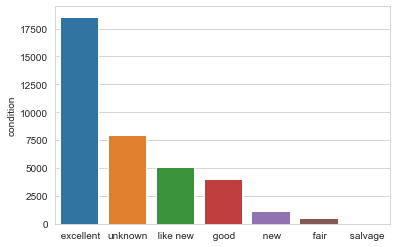

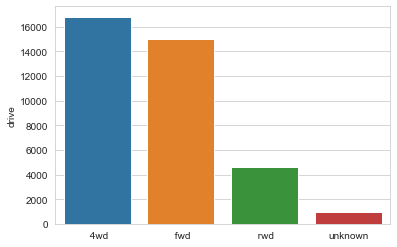

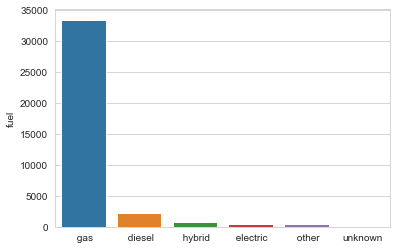

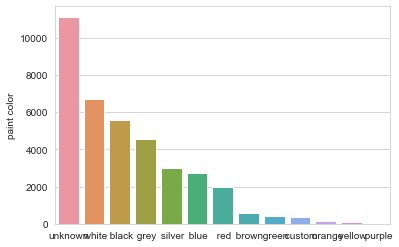

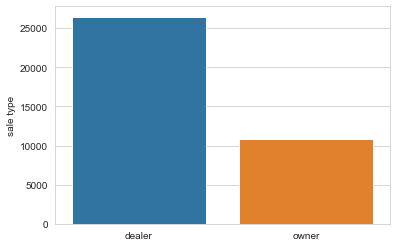

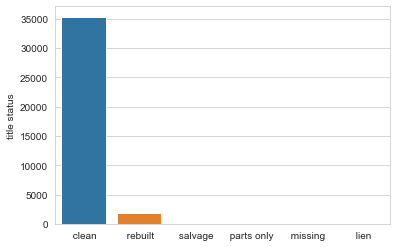

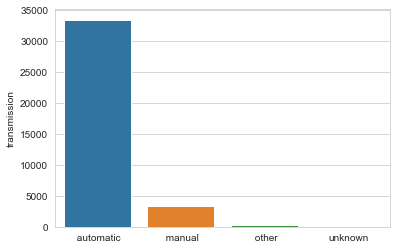

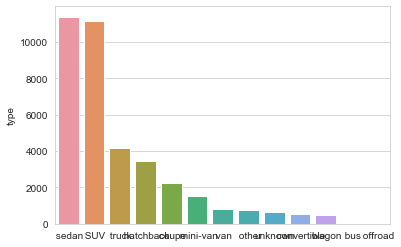

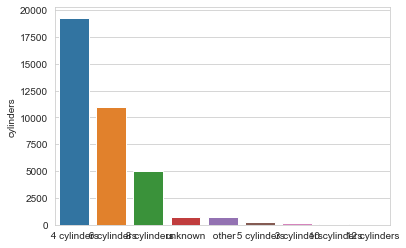

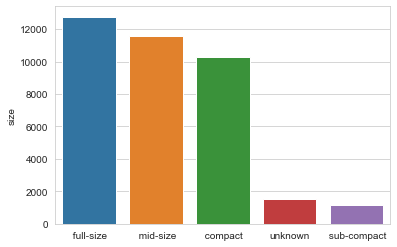

In [3]:
#Plot histograms of some of the indicator variables to better understand the distribution of data.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

for col in ['condition', 'drive', 'fuel', 'paint color', 'sale type', 'title status', 'transmission', 'type', 
            'cylinders', 'size']:
    dat = cars[col].value_counts()
    sns.barplot(x = dat.index, y = dat)
    plt.show()

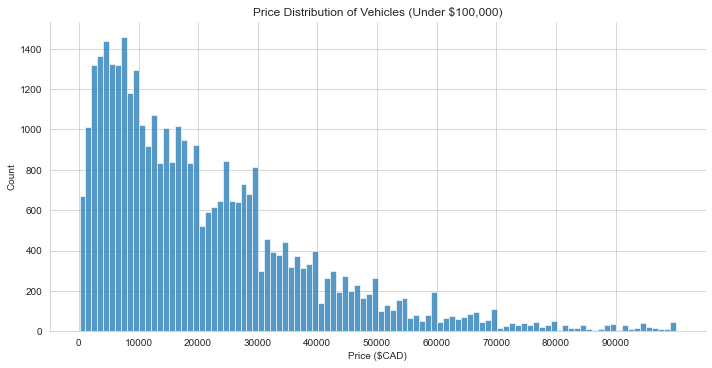

In [4]:
#plot price histogram
cars = cars[cars.price<1e5]

sns.displot(cars, x='price', binwidth=1000, height=5, aspect=2)#, bw_adjust=0.4)
plt.xticks(range(0,int(1e5), int(1e4)))
plt.xlabel('Price ($CAD)')
plt.title('Price Distribution of Vehicles (Under $100,000)')
plt.show()

Price distribution for all of the vehichles. The overall distribution is skewed right, with the most common price being between \\$3,000-\\$8,000.

Note the dips in price at multiples of \\$10,000. This indicates a psychological pricing strategy (eg.  asking \\$19,000 instead of \\$20,000 in hopes that the price will seem lower than it actually is).

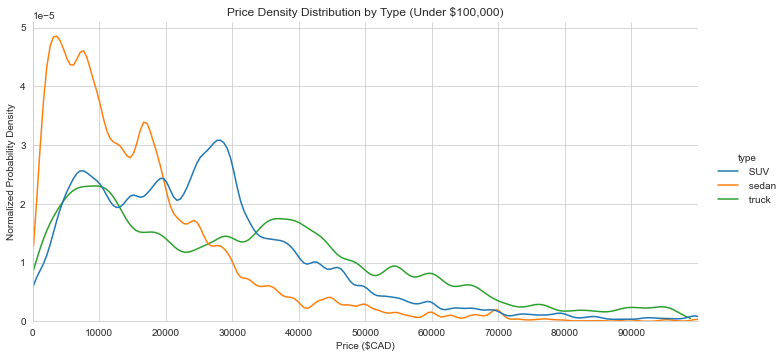

In [5]:
#plot pricing probability density for different types of vehicle
cars_plt = cars[cars.type.isin([' sedan', ' SUV', ' truck'])]
sns.displot(cars_plt, x='price', hue='type', kind='kde', bw_adjust=0.4, cut=0, common_norm=False, height=5, aspect=2)#, bw_adjust=0.4)
plt.xticks(range(0,int(1e5), int(1e4)))
plt.xlabel('Price ($CAD)')
plt.xlim(0,int(1e5))
plt.ylabel('Normalized Probability Density')
plt.title('Price Density Distribution by Type (Under $100,000)')
plt.show()

Probability density of price for sedans, SUVs, and Trucks. The curves hve been noramlized so the area under each curve is 1. Sedans are the most skewed to the low price end. SUVs and trucks have lower end options (under \\$10,000) but are also commonly found in the \\$30,000-\\$40,000 range. The psychological strategy of pricing just under multiples of \\$10,000 is more apparent here. This might be a good strategy on Craigslist as potential buyers might tend to use the pricing filter on their search with a bands at a round numbers.

Another interesting feature is the dip in trucks between \\$15,000 and \\$30,000, this may indicate there is less turnover in trucks for this price. Perhaps this means people are happy with their trucks in this range, so if you find one it could be a good buy.

In [6]:
#take a look at the mean year and odometer for trucks in this range
cars[(cars.type==' truck') & (15000<cars.price) & (cars.price<30000)].mean()[['odometer', 'year']]

odometer    183294.729730
year          2010.493537
dtype: float64

It appears that a 2010 truck with 170,000km for might be a good buy if someone is willing to part with it.

We now turn our attention to developing a contourplot of price vs odometer and year to get an an idea of how vehichles depreciate over their lifetime. This task is complicated by the noise in the pricing data (ie. for a given year and odometer reading, there can be many different prices in the dataset). We will get around this by converting our pricing data to a moving average over odometer readting and year.

Before the average can be taken, we must first interpolate our data to a uniform grid.

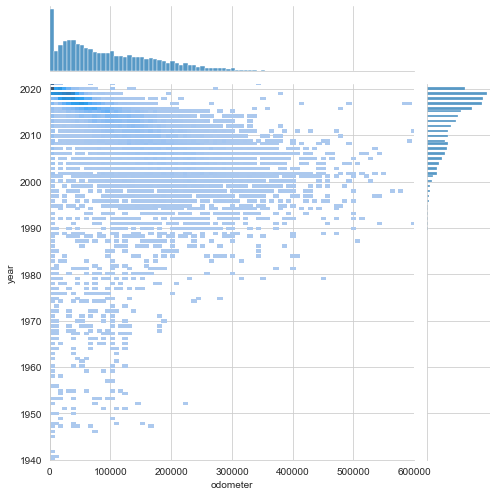

In [9]:
#plot distribution of vehicles over odometer reading and year
cars = cars[cars.odometer<1e6]

g = sns.JointGrid(data=cars, x='odometer', y='year', height = 7, xlim = (0, 6e5), ylim=(1940, 2021))
g.plot_joint(sns.histplot)
g.plot_marginals(sns.histplot)
plt.show()

Text(0.5, 1.0, 'cubic')

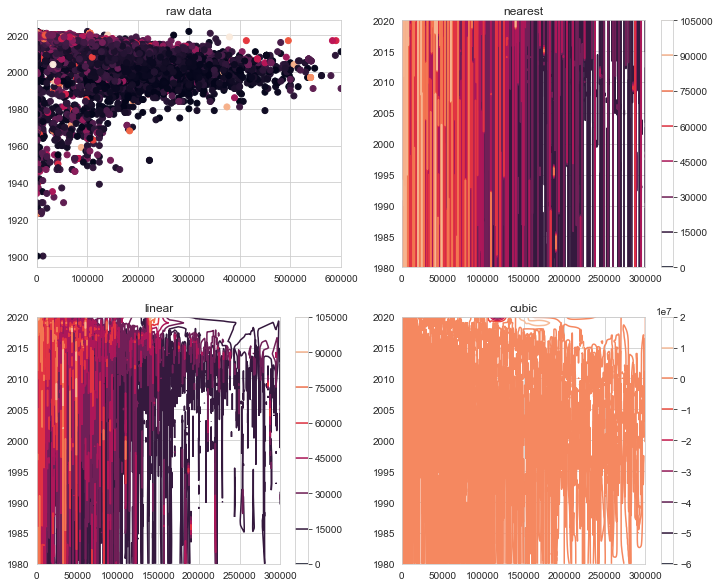

In [7]:
#interpolate pricing data using several different methods
from scipy.interpolate import griddata
#available sample data for the contour plot
xs = cars['odometer']
ys = cars['year']
zs = cars['price']
points = np.array([xs, ys]).T
#desired data-grid we wish to interpolate this data onto
grid_x, grid_y = np.meshgrid(np.linspace(0,3e5,5000), np.arange(1980,2021,1))

#try out three different methods of interpolation
grid_z0 = griddata(points, zs, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, zs, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, zs, (grid_x, grid_y), method='cubic')

fig, axs = plt.subplots(2, 2, figsize=(12,10))
axs[0,0].scatter(xs, ys, c=zs)
axs[0,0].set_xlim(0,6e5)
axs[0,0].set_title('raw data')

im = axs[0,1].contour(grid_x, grid_y, grid_z0)
fig.colorbar(im, ax=axs[0,1])
axs[0,1].set_title('nearest')

im = axs[1,0].contour(grid_x, grid_y, grid_z1)
fig.colorbar(im, ax=axs[1,0])
axs[1,0].set_title('linear')

im = axs[1,1].contour(grid_x, grid_y, grid_z2)
fig.colorbar(im, ax=axs[1,1])
axs[1,1].set_title('cubic')

All three methods are clearly very noisy but the cubic method is prodocing unrealistic values so will not be used. We will proceed with the 'nearest' interpolation method for simplicity.

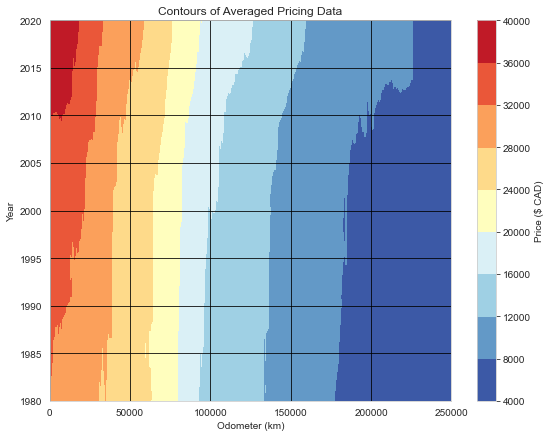

In [8]:
#Filter out noise in the interpolated dataset and plot the final contour.
from scipy.signal import convolve2d
sz_o = 500 #size of averaging window for odometer
sz_y = 3 #size of averaging window for year
kernel = np.ones((sz_y,sz_o))/(sz_y*sz_o)#averaging kernel, corresponds to averaging over +-15000 km and +-1 year
grid_z0f = convolve2d(grid_z0, kernel, boundary='symm', mode='same')#run a moving average over the 'nearest' interpolated dataset

fig, ax = plt.subplots(1, figsize=(9,7))
im = ax.contourf(grid_x, grid_y, grid_z0f, levels=10, cmap='RdYlBu_r', zorder=0)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Price ($ CAD)')
ax.set_xlim(0, 2.5e5)
ax.set_xlabel('Odometer (km)')
ax.set_ylabel('Year')
ax.set_title('Contours of Averaged Pricing Data')
ax.grid(True, color='k')
plt.show()

So odometer reading is much more important than year to determine price. According to this data, a newer vehicle would only loose ~20\% (\\$8,000) of its value after 40 years with no driving. On the other hand, the same vehicle driven 50,000km in one year would lose 20-30\% of its value.

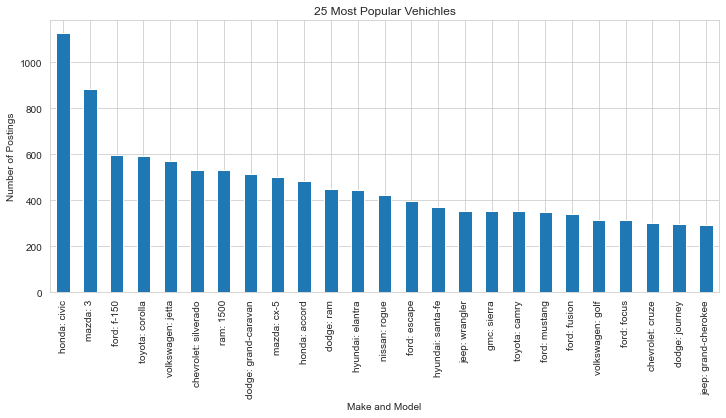

In [10]:
#column with the make and model in one (for plotting)
cars['make_model0'] = cars['make_'] + ': ' + cars['model0']
#plot 20 most popular cars
com_cars = cars.make_model0.value_counts()[:25]
fig = com_cars.plot.bar(figsize=(12,5))
plt.xlabel('Make and Model')
plt.ylabel('Number of Postings')
plt.title('25 Most Popular Vehichles')
plt.show()

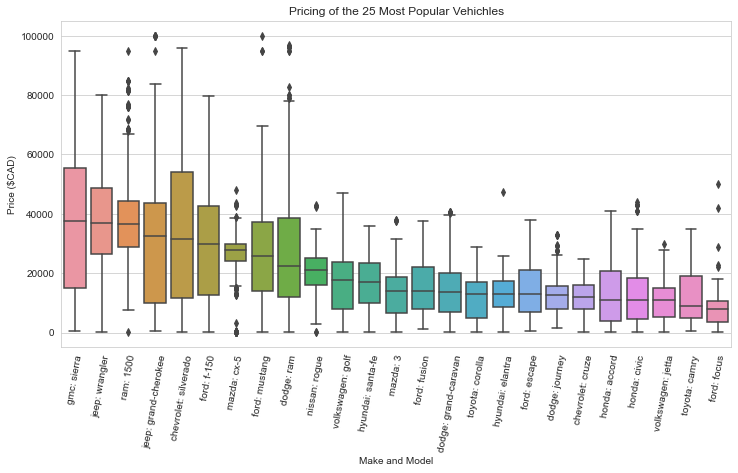

In [11]:
#plot the average prices of the 25 most popular cars
com_price = cars.loc[cars.make_model0.isin(com_cars.index)]#.median().sort_values(ascending=False)
ordered_labels = com_price.groupby('make_model0').price.median().sort_values(ascending=False).index.values

fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=com_price, x="make_model0", y="price", order=ordered_labels, ax=ax)
plt.xticks(rotation = 80)
plt.xlabel('Make and Model')
plt.ylabel('Price ($CAD)')
plt.title('Pricing of the 25 Most Popular Vehichles')
plt.show()

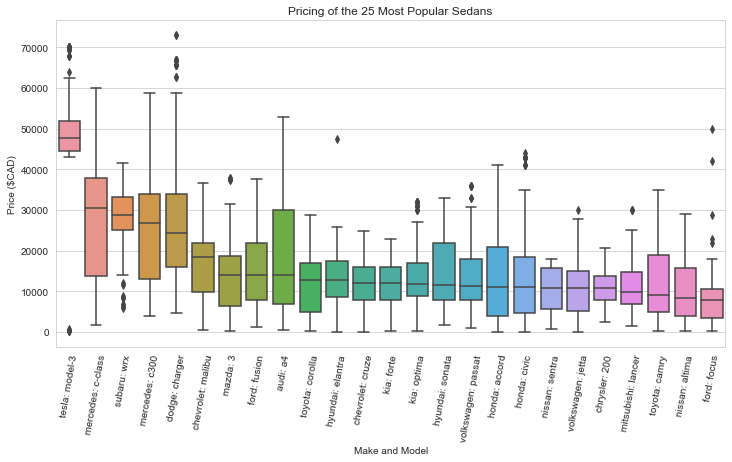

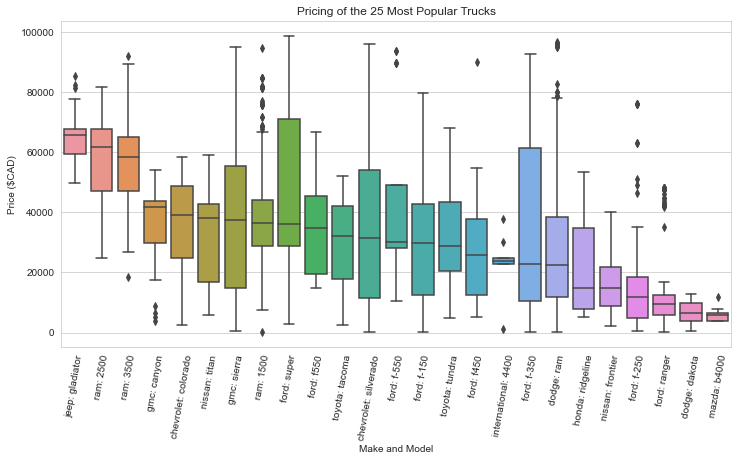

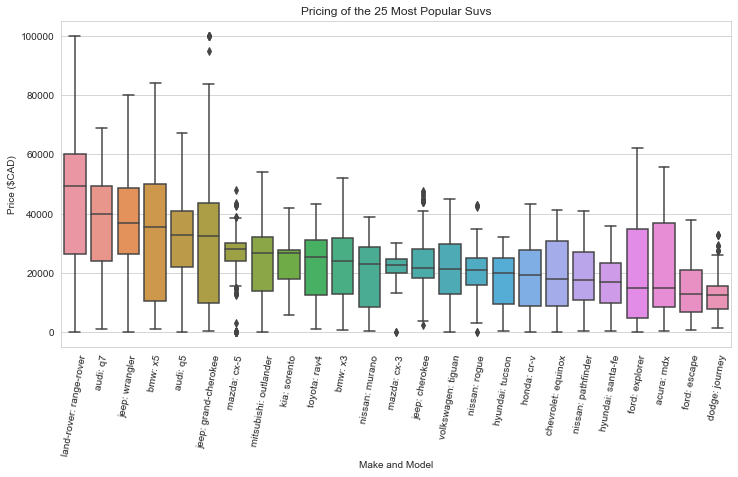

In [12]:
#plot the average prices of the 25 most popular trucks, trucks, and SUVS

for thing in [' sedan', ' truck', ' SUV']:
    com = cars[cars['type']==thing].make_model0.value_counts()[0:25].index
    com_price = cars.loc[cars.make_model0.isin(com)]
    ordered_labels = com_price.groupby('make_model0').price.median().sort_values(ascending=False).index.values
    
    fig, ax = plt.subplots(figsize=(12,6))
    sns.boxplot(data=com_price, x="make_model0", y="price", order=ordered_labels, ax=ax)
    plt.xticks(rotation = 80)

    plt.xlabel('Make and Model')
    plt.ylabel('Price ($CAD)')
    plt.title('Pricing of the 25 Most Popular {}s'.format(thing[1:].capitalize()))
    plt.show()

In [13]:
#map distribution of vehichles
import geopandas as gpd
gdf = gpd.GeoDataFrame(
    cars, geometry=gpd.points_from_xy(cars.longitude, cars.latitude))
#remove data outside the geographic area of interest
gdf = gdf[(48<gdf.latitude) & (gdf.latitude<52) & (-127<gdf.longitude) & (gdf.longitude<-115)]
#tell geopandas what the coordinate system of our data is
gdf = gdf.set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=3857)

(6150000.0, 6650000.0)

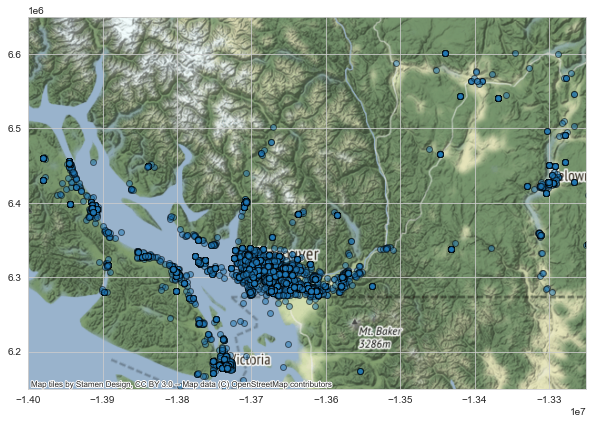

In [14]:
#plot the geographic area where data was collected at the points of the vehicles
import contextily as ctx
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=7)
plt.xlim(-1.4e7,-1.325e7)
plt.ylim(6.15e6,6.65e6)

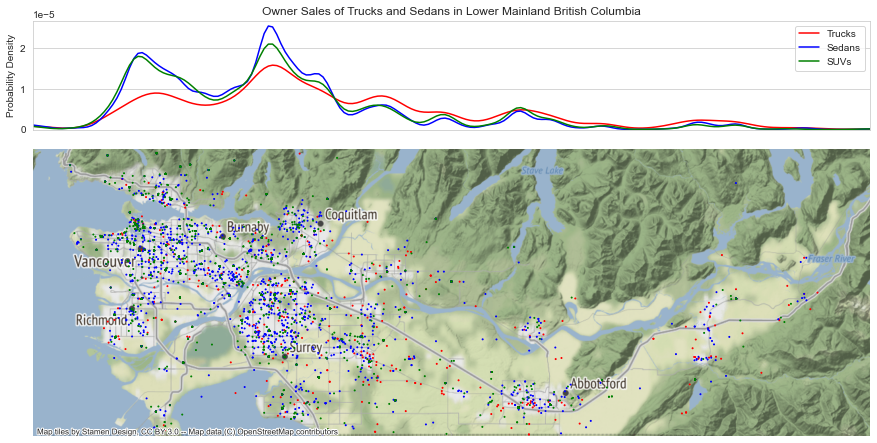

In [15]:
#plot the distribution of sedans, trucks, and suvs in the area around Vancouver
import geoplot
extent = (-1.373e7,-1.354e7, 6.275e6,6.34e6)

gtrucks = gdf[(gdf['type']==' truck') & (gdf['sale type']=='owner')]
gsedans = gdf[(gdf['type']==' sedan') & (gdf['sale type']=='owner')]
gsuvs = gdf[(gdf['type']==' SUV') & (gdf['sale type']=='owner')]
trucks= pd.Series(gtrucks.geometry.x)
sedans= pd.Series(gsedans.geometry.x)
suvs= pd.Series(gsuvs.geometry.x)

fig, ax = plt.subplots(2, figsize=(15, 8), gridspec_kw={'height_ratios': [1, 3], 'hspace':0})

sns.kdeplot(data=trucks, ax=ax[0], clip=(extent[0], extent[1]), bw_adjust=0.15, label='Trucks', color='red')
sns.kdeplot(data=sedans, ax=ax[0], clip=(extent[0], extent[1]), bw_adjust=0.15, label='Sedans', color='blue')
sns.kdeplot(data=suvs, ax=ax[0], clip=(extent[0], extent[1]), bw_adjust=0.15, label='SUVs', color='green')
ax[0].set_xlim(extent[0], extent[1])
ax[0].set_ylabel('Probability Density')
ax[0].set_title('Owner Sales of Trucks and Sedans in Lower Mainland British Columbia')
ax[0].set_xticks([])
ax[0].legend()

geoplot.pointplot(gtrucks, ax=ax[1], s=1, color='red')
geoplot.pointplot(gsedans, ax=ax[1], s=1, color='blue')
geoplot.pointplot(gsuvs, ax=ax[1], s=1, color='green')
ax[1].axis(extent)
ctx.add_basemap(ax[1], zoom=10)

plt.show()

The plot above shows the distribution of sedan, suv, and truck sales by owner in lower mainland BC (where the heighest concentration of data is located). The top probability density curves show the normalized distribution of each vehicle type over longitude. As expected, distinct peaks in both curves occur around Vancouver/Richmond and Surrey where many sales are located. 

Note that sedan and SUVs sales are more highly concentrated in the urban centres and truck sales are more evenly distribued. While it might be intuitive that trucks are more likely to be found in the suburbs, it is intersting to note that SUVs are found in high proportion in the city centres alongside sedans.

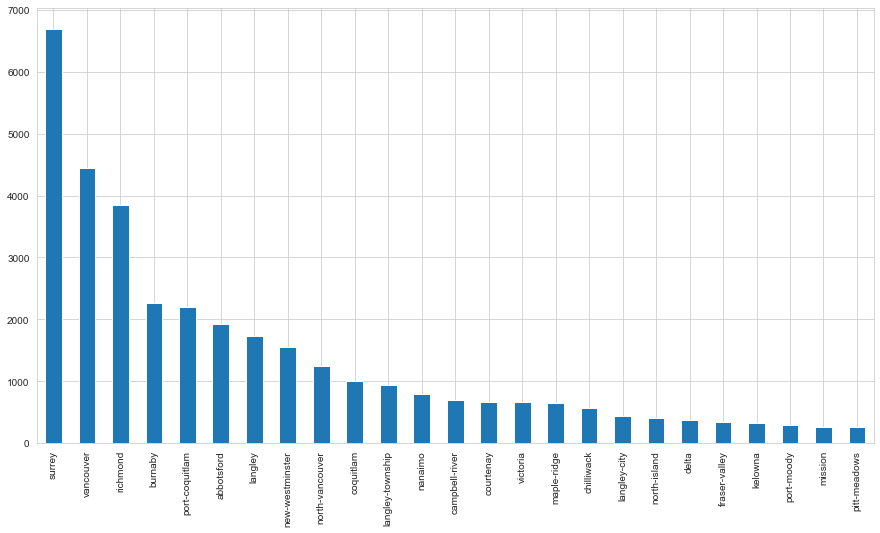

In [16]:
fig = cars.location_simple.value_counts()[0:25].plot.bar(figsize=(15,8))
plt.show()

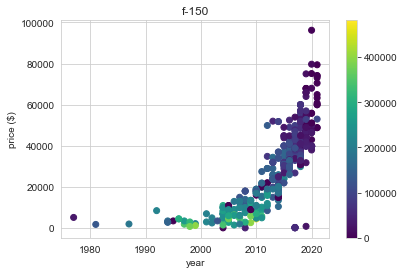

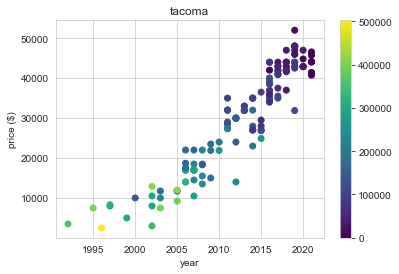

In [17]:
names = ['f-150', 'tacoma']
for name in names:
    df = cars[(cars['model0']==name) & (cars['drive']==' 4wd')]
    trucks = plt.scatter(x = df['year'], y = df['price'], c=df['odometer'], cmap='viridis')
    plt.colorbar(trucks)
    plt.xlabel('year')
    plt.ylabel('price ($)')
    plt.title(name)
    plt.show()

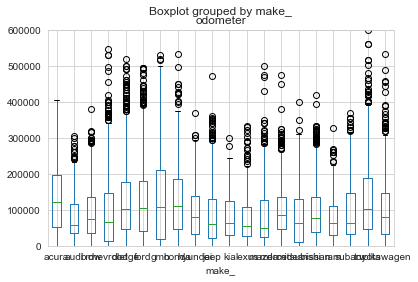

In [18]:
#boxplot odometer vs make
pop_makes = cars['make_'].value_counts()[:20].index.values
cars[cars['make_'].isin(pop_makes)].boxplot(column='odometer', by='make_')
plt.ylim(0, 600000)
plt.show()

In [ ]:
def get_missing_info(df):
    num_entries = df.shape[0]*df.shape[1]
    null_entries = df.isnull().sum().sum()
    percent_empty = null_entries/num_entries*100
    num_missing = df.isna().sum()
    percent_missing = num_missing/len(df)*100
    col_modes = df.mode().loc[0]
    percent_mode = [df[x].isin([df[x].mode()[0]]).sum()/len(df)*100 for x in df]
    missing_value_df = pd.DataFrame({'num_missing': num_missing,
                                     'percent_missing': percent_missing, 
                                     'mode': col_modes,
                                     'percent_mode':percent_mode})
    print('total empty percent:', percent_empty, '%')
    print('columns that are more than 97% mode:', missing_value_df.loc[missing_value_df['percent_mode']>97].index.values)
    return(missing_value_df)
get_missing_info(cars)